![tower_bridge](tower_bridge.jpg)

As the climate changes, predicting the weather becomes ever more important for businesses. You have been asked to support on a machine learning project with the aim of building a pipeline to predict the climate in London, England. Specifically, the model should predict mean temperature in degrees Celsius (°C).

Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `mlflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [123]:
# Run this cell to install mlflow
!pip install mlflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [124]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv")

# Start coding here
# Use as many cells as you like

In [125]:
# Filter rows where there is at least one null value in any column
rows_with_nulls = weather[weather.isnull().any(axis=1)]

# Display the filtered rows
rows_with_nulls

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
14,19790115,NaN,0.0,15.0,5.9,3.8,1.0,0.1,102990.0,0.0
20,19790121,NaN,0.0,16.0,1.5,0.0,-3.5,0.1,102170.0,0.0
37,19790207,NaN,0.0,21.0,3.7,3.3,-0.2,0.4,99450.0,0.0
50,19790220,NaN,0.0,27.0,3.6,1.6,0.3,0.0,103010.0,0.0
56,19790226,NaN,4.2,82.0,8.9,1.6,-3.4,0.0,103590.0,0.0
...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


In [126]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


# Data validation


In [127]:
# Checking if there are any duplicates
weather.duplicated().any()

False

In [128]:
summary_df = pd.DataFrame()
summary_df['Percentage Null Values'] = round(weather.isnull().sum() / weather.shape[0] * 100, 2)
summary_df['Number Unique Values'] = weather.nunique()
print(summary_df)

                  Percentage Null Values  Number Unique Values
date                                0.00                 15341
cloud_cover                         0.12                    10
sunshine                            0.00                   160
global_radiation                    0.12                   360
max_temp                            0.04                   374
mean_temp                           0.23                   321
min_temp                            0.01                   296
precipitation                       0.04                   262
pressure                            0.03                   642
snow_depth                          9.39                    19


In [129]:
weather.drop('date', axis=1).describe().round(2)

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,15322.00,15341.00,15322.00,15335.00,15305.00,15339.00,15335.00,15337.00,13900.00
mean,5.27,4.35,118.76,15.39,11.48,7.56,1.67,101536.61,0.04
std,2.07,4.03,88.90,6.55,5.73,5.33,3.74,1049.72,0.55
min,0.00,0.00,8.00,-6.20,-7.60,-11.80,0.00,95960.00,0.00
25%,4.00,0.50,41.00,10.50,7.00,3.50,0.00,100920.00,0.00
50%,6.00,3.50,95.00,15.00,11.40,7.80,0.00,101620.00,0.00
75%,7.00,7.20,186.00,20.30,16.00,11.80,1.60,102240.00,0.00
max,9.00,16.00,402.00,37.90,29.00,22.30,61.80,104820.00,22.00


# Data Cleaning

In [130]:
weather['snow_depth'].fillna(0, inplace=True)

In [131]:
# Fill missing values using forward fill (ffill)
weather = weather.ffill()

# Exploratory analysis

In [132]:
# sns.pairplot(weather.drop('date', axis=1))
# plt.show()

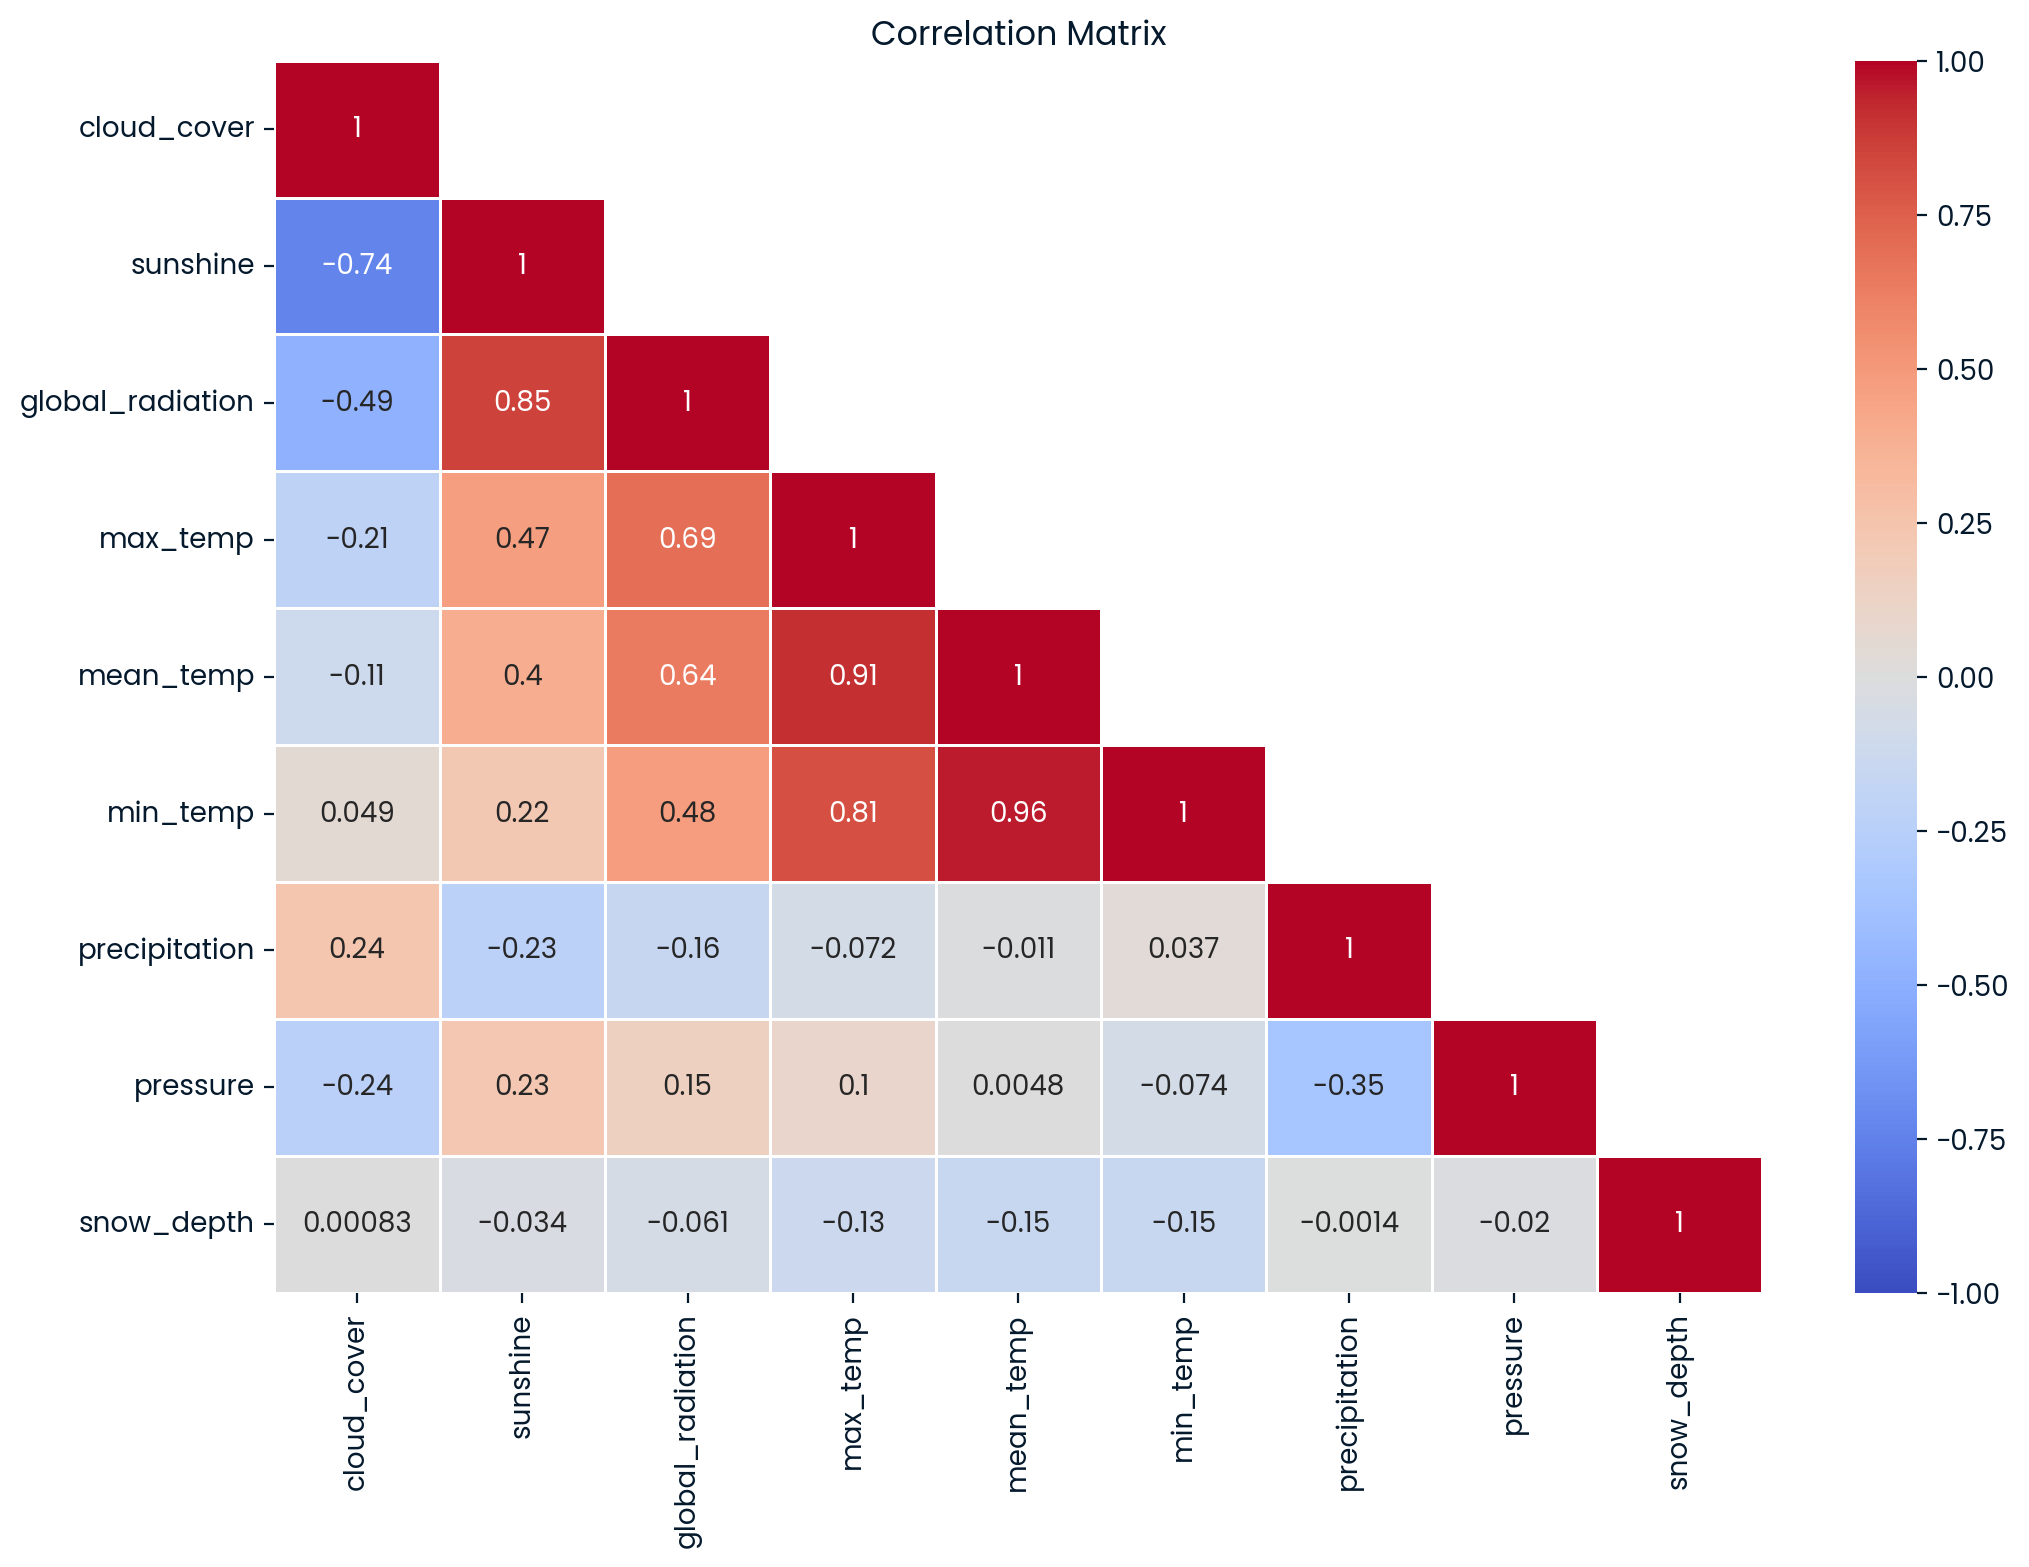

In [133]:
# Compute correlation matrix
corr_matrix = weather.drop('date', axis=1).corr()

# Create mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Plot the heatmap
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                      linewidths=0.5, vmin=-1, vmax=1, mask=mask)

# Customize the y-axis tick labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, horizontalalignment='right')

# Add title
plt.title('Correlation Matrix')

# Display the plot
plt.show()

# Model Development

In [134]:
weather['temp_diff'] = np.abs(weather.max_temp - weather.min_temp)
weather.drop(columns=['max_temp', 'min_temp'], inplace=True)

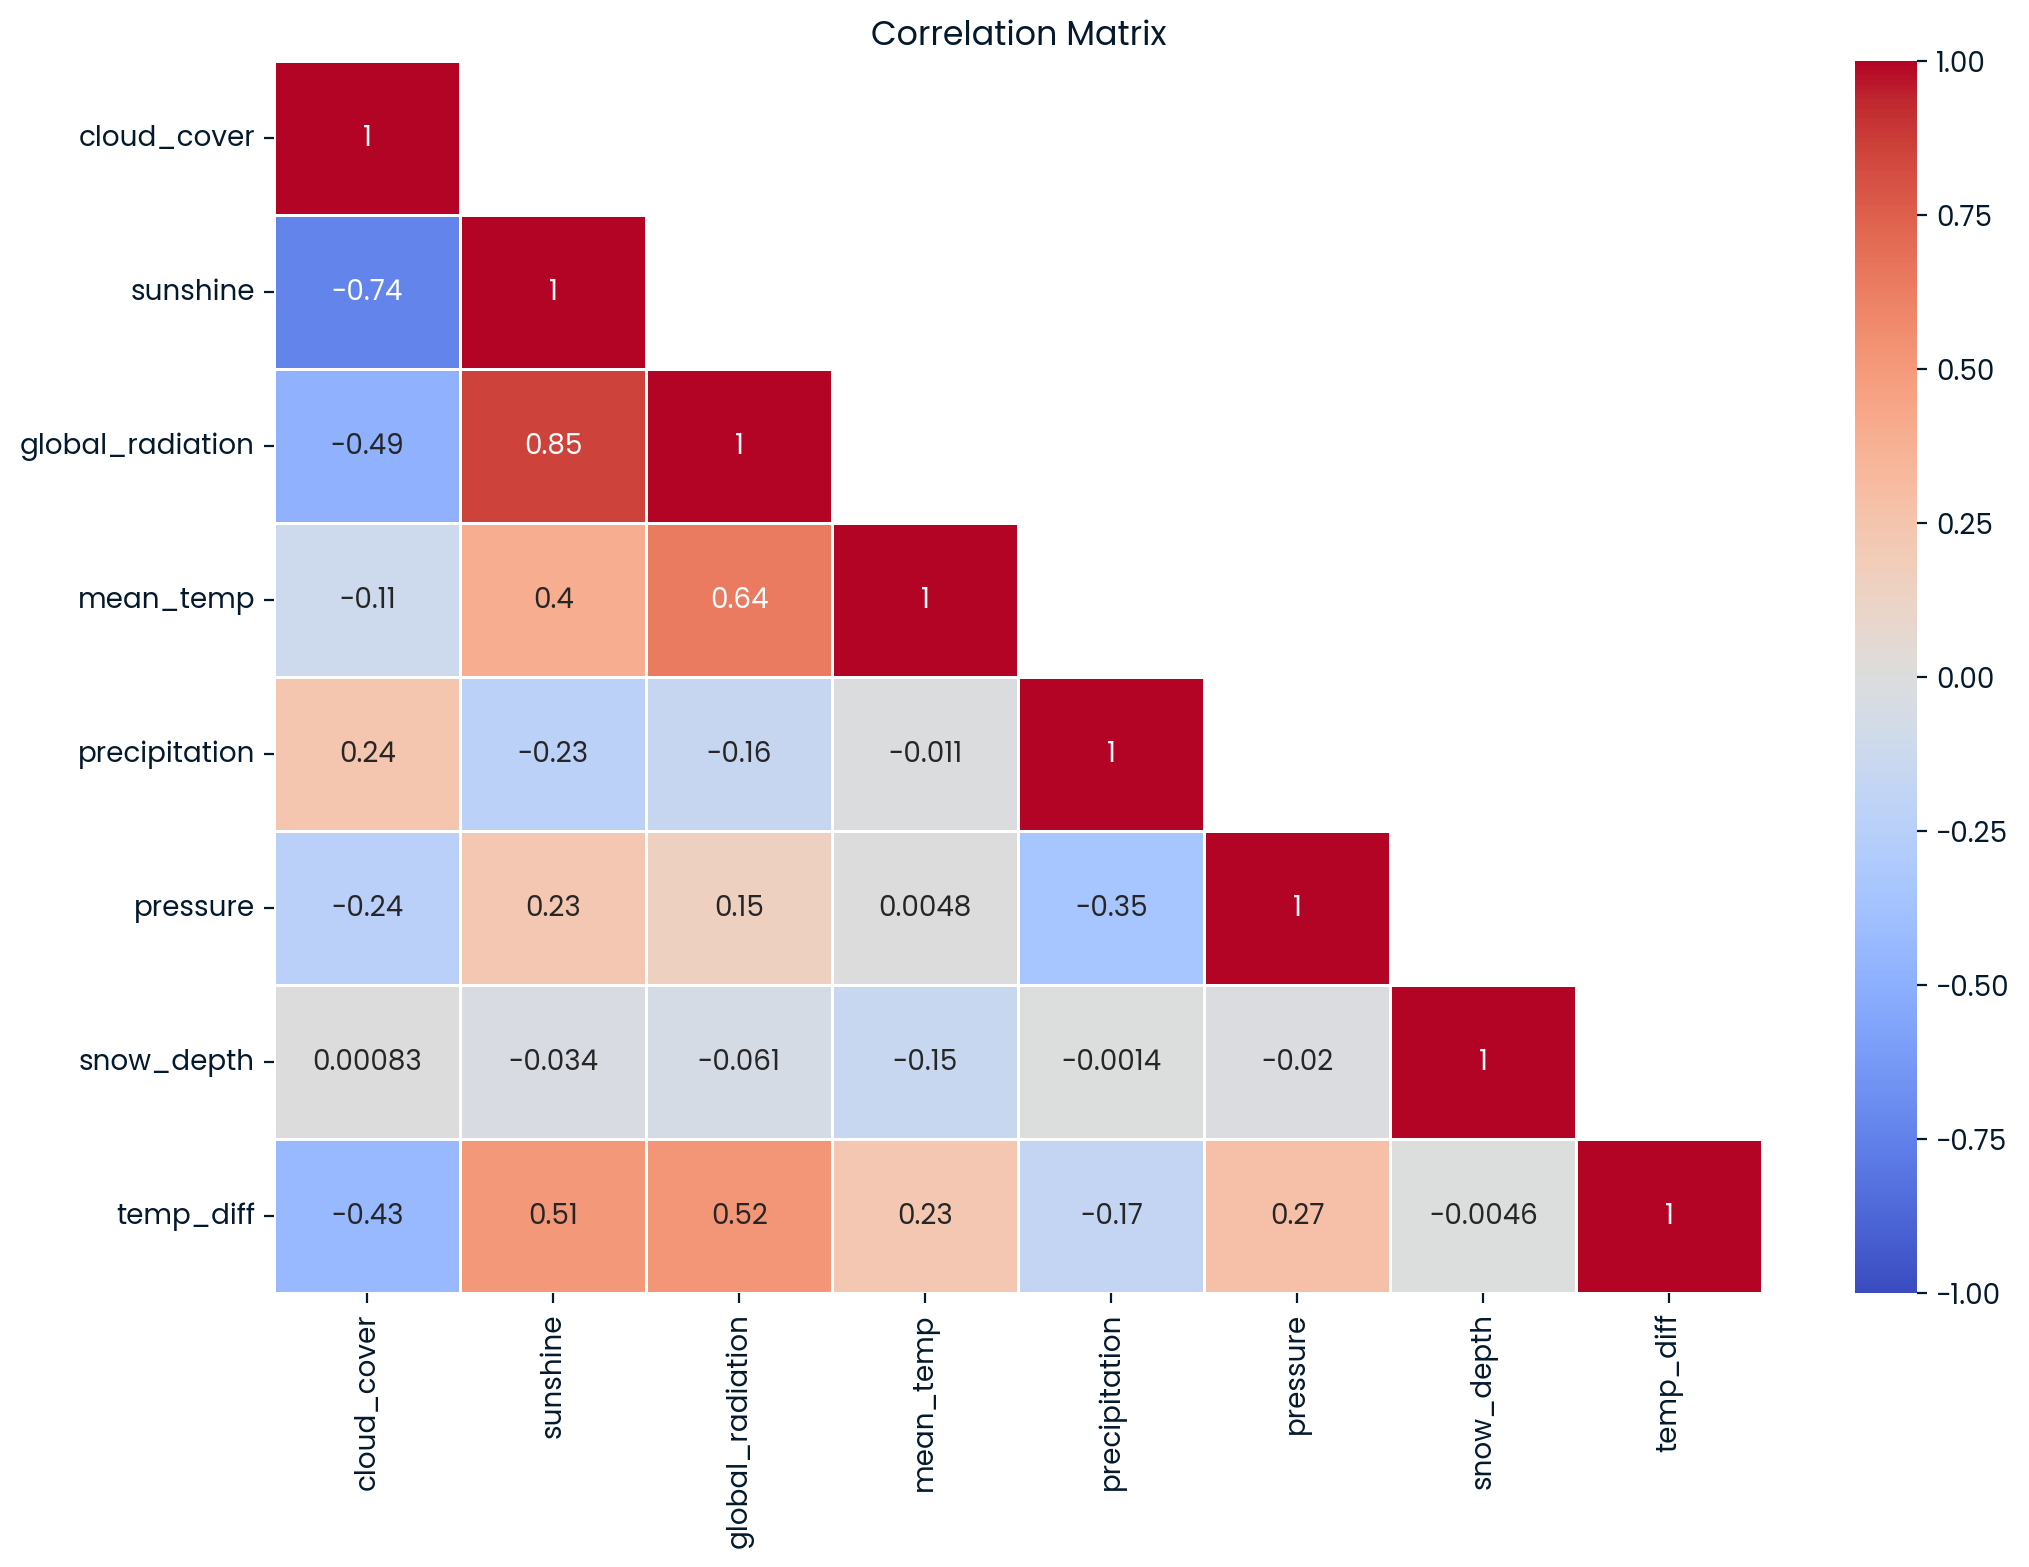

In [135]:
# Compute correlation matrix
corr_matrix = weather.drop('date', axis=1).corr()

# Create mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Plot the heatmap
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                      linewidths=0.5, vmin=-1, vmax=1, mask=mask)

# Customize the y-axis tick labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, horizontalalignment='right')

# Add title
plt.title('Correlation Matrix')

# Display the plot
plt.show()

In [136]:
# Splitting DataFrame into target column and features columns.
X = weather.drop(columns=['date', 'mean_temp'], axis=1)
y = weather['mean_temp']

# Split the data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111)

In [137]:
mlflow.set_experiment("London_Weather_Prediction")

with mlflow.start_run():
    # Initialize and train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Log parameters & metrics to MLflow
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("R2_score", r2)

    # Log model
    mlflow.sklearn.log_model(model, "linear_regression_model")

    print(f"Model logged with MAE: {mae}, RMSE: {rmse}, R2: {r2}")


Model logged with MAE: 3.2367665965442827, RMSE: 4.048958302152136, R2: 0.49786409447776026


In [138]:
# Convert to datetime
weather["date"] = pd.to_datetime(weather["date"].astype(str), format="%Y%m%d")

# Extract year, month, and day of the year
weather["year"] = weather["date"].dt.year  # Keep as an integer
weather["month"] = weather["date"].dt.month
weather["day_of_year"] = weather["date"].dt.dayofyear

# Encode month and day cyclically
weather["month_sin"] = np.sin(2 * np.pi * weather["month"] / 12)
weather["month_cos"] = np.cos(2 * np.pi * weather["month"] / 12)
weather["day_sin"] = np.sin(2 * np.pi * weather["day_of_year"] / 365)
weather["day_cos"] = np.cos(2 * np.pi * weather["day_of_year"] / 365)

# Drop original month and day columns (since we've encoded them)
weather.drop(columns=["month", "day_of_year", "date"], inplace=True)


In [139]:
# Splitting DataFrame into target column and features columns.
X = weather.drop(columns=['mean_temp'], axis=1)
y = weather['mean_temp']

# Split the data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=112)

In [140]:
experiment_name = "London_Weather_Prediction"  # Keep the same experiment
mlflow.set_experiment(experiment_name)  # Ensures all runs are tracked under the same project

with mlflow.start_run():  
    # Log new parameters (e.g., using year + cyclic month encoding)
    mlflow.log_param("Feature_Engineering", "Added year, month_sin, day_sin")  
    mlflow.log_param("Model", "Linear Regression")

    # Train the model again
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate new performance
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Log parameters & metrics to MLflow
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("R2_score", r2)
    
    # Save model
    mlflow.sklearn.log_model(model, "linear_regression_model")
    
    print(f"Model logged with RMSE: {rmse}")


Model logged with RMSE: 2.795247332877617


In [141]:
experiment_results = mlflow.search_runs()
experiment_results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse,metrics.R2_score,metrics.MAE,metrics.MSE,metrics.RMSE,params.model_type,params.Model,params.Feature_Engineering,tags.mlflow.log-model.history,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type
0,2617cde53e374eadaf5dc9927e2c1e60,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,2025-02-09 07:36:29.288000+00:00,2025-02-09 07:36:33.332000+00:00,2.795247,0.762539,2.266046,7.813408,NaN,LinearRegression,Linear Regression,"Added year, month_sin, day_sin","[{""run_id"": ""2617cde53e374eadaf5dc9927e2c1e60""...",invincible-robin-623,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL
1,8eb64d37793b4718bd51223a5fe5bd9c,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,2025-02-09 07:36:25.020000+00:00,2025-02-09 07:36:28.936000+00:00,4.048958,0.497864,3.236767,16.394063,NaN,LinearRegression,None,None,"[{""run_id"": ""8eb64d37793b4718bd51223a5fe5bd9c""...",stylish-sheep-378,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL
2,084c69f2182b44afb074544ce6726703,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,2025-02-09 07:35:25.363000+00:00,2025-02-09 07:35:29.360000+00:00,NaN,0.762539,2.266046,7.813408,2.795247,LinearRegression,Linear Regression,"Added year, month_sin, day_sin","[{""run_id"": ""084c69f2182b44afb074544ce6726703""...",mysterious-mare-108,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL
3,adc3985873ab4f4ea7a2929c93155eaf,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,2025-02-09 07:35:21.144000+00:00,2025-02-09 07:35:25.052000+00:00,NaN,0.497864,3.236767,16.394063,4.048958,LinearRegression,None,None,"[{""run_id"": ""adc3985873ab4f4ea7a2929c93155eaf""...",nebulous-midge-808,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL
4,a7c7e57927444ca7a3b4dd489bdd2799,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,2025-02-09 07:33:25.751000+00:00,2025-02-09 07:33:29.731000+00:00,NaN,0.762539,2.266046,7.813408,2.795247,LinearRegression,Linear Regression,"Added year, month_sin, day_sin","[{""run_id"": ""a7c7e57927444ca7a3b4dd489bdd2799""...",flawless-cub-291,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL
5,0d704c27f6914f0e89e820ccb14528ee,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,2025-02-09 07:33:21.522000+00:00,2025-02-09 07:33:25.449000+00:00,NaN,0.497864,3.236767,16.394063,4.048958,LinearRegression,None,None,"[{""run_id"": ""0d704c27f6914f0e89e820ccb14528ee""...",gaudy-koi-760,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL
6,07dc212f08944160a18053be974ee244,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,2025-02-09 07:28:08.443000+00:00,2025-02-09 07:28:12.143000+00:00,NaN,NaN,NaN,NaN,2.795247,None,Linear Regression,"Added year, month_sin, day_sin","[{""run_id"": ""07dc212f08944160a18053be974ee244""...",popular-squid-532,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL
7,2b5fae25504c4b6284fac96fab0493ca,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,2025-02-09 07:28:04.296000+00:00,2025-02-09 07:28:08.129000+00:00,NaN,0.497864,3.236767,16.394063,4.048958,LinearRegression,None,None,"[{""run_id"": ""2b5fae25504c4b6284fac96fab0493ca""...",masked-wolf-449,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL
8,e30474644b7e4ef1869c1560de11b860,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,2025-02-09 07:27:11.002000+00:00,2025-02-09 07:27:14.782000+00:00,NaN,NaN,NaN,NaN,2.795247,None,Linear Regression,"Added year, month_sin, day_sin","[{""run_id"": ""e30474644b7e4ef1869c1560de11b860""...",magnificent-yak-279,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL
9,c0656105639a4a99818b79a0f61c482c,610473314524365671,FINISHED,file:///work/files/workspace/mlruns/6104733145...,